## Simulation Analysis

1. True population density analysis (model precision and accuracy) of entire data set. Between total hits and actual hits.

2. Density estimation changes between multiple combinations (animals, paths, camera, uav_paths, uav_speed, bias)

Loading in simulations and packages ..

In [118]:
#clear environments
rm(list=ls())

library(dplyr)
library(geosphere)
library(reshape2)
library(ggplot2)
library(ggthemes)

# Run 1 simulations
sim1 <- read.csv("../Data/Simulations/Run_1/sim1.csv", header = T)
sim2 <- read.csv("../Data/Simulations/Run_1/sim2.csv", header = T)
sim3 <- read.csv("../Data/Simulations/Run_1/sim3.csv", header = T)
sim4 <- read.csv("../Data/Simulations/Run_1/sim4.csv", header = T)
sim5 <- read.csv("../Data/Simulations/Run_1/sim5.csv", header = T)
sim6 <- read.csv("../Data/Simulations/Run_1/sim6.csv", header = T)
sim7 <- read.csv("../Data/Simulations/Run_1/sim7.csv", header = T)
sim8 <- read.csv("../Data/Simulations/Run_1/sim8.csv", header = T)
sim9 <- read.csv("../Data/Simulations/Run_1/sim9.csv", header = T)
sim10 <- read.csv("../Data/Simulations/Run_1/sim10.csv", header = T)
sim11 <- read.csv("../Data/Simulations/Run_1/simsim1.csv", header = T)

# Timesteps of simulation runs
timestep <- 1000

current_sims <- list(sim1, sim2, sim3, sim4, sim5, sim6, sim7, sim8, sim9, sim10, sim11)
all_sims <- rbind(sim1, sim2, sim3, sim4, sim5, sim6, sim7, sim8, sim9, sim10, sim11)

### Summary Stats

In [119]:
# Number of combinations of variables: 1344
no_runs <- length(current_sims)
no_simulations <- no_runs*1344

# Hit histograms

Actual_hit_plot <- ggplot(data = all_sims) + 
                      geom_histogram(aes(x=Actual_hits), fill = 'red',  binwidth = 0.5) 

Total_hit_plot <- ggplot(data = all_sims) +
                      geom_histogram(aes(x=Total_hits), fill = 'blue', position = "identity", binwidth = 0.5)

ave_encounter_rate <- mean(all_sims$Actual_hits) # Taking into account all those 0 values
common_e_rate <- median(all_sims$Actual_hits)

# Proportion of hits vs. non-hits
non_zero_sims <- subset(all_sims, all_sims$Actual_hits > 0)
Prop_hits <- nrow(non_zero_sims)/nrow(all_sims)
#Prop_hits

### Model Precision and Accuracy

Model accuracy of entire datset means that we calculate the density of each simulation and compare it to the mean density of all simulations (true mean density). The standard deviation from the true mean density informs us of model accuracy.

**True simulation density then is not the actual density of animals in that area but rather the mean calculated density from x number of simulations. I would have initially assumed the true simulation density to be 1 (there's one animal in the simulation)** but that is never really the case when encounters are expressed as a ratio of area.

Must first calculate area covered in each simulation (fix in simulation later)

In [120]:
# Area covered by each camera appended to simulation data
cam_name <- c("garmin", "sony", "nadir")
cam_area <- c(9.296,8.475,17.876) # Already in kilometres
cam_table <- data.frame(cam_name, cam_area)


calcArea <- function(df){
    # Area of each camera
    area_covered <- c()
    for(i in df$Camera){
      if(i == "garmin"){
        area_covered <- c(area_covered, cam_table[1,2])
      }
      if(i == "sony"){
        area_covered <- c(area_covered, cam_table[2,2])
      }
      if(i == "nadir"){
        area_covered <- c(area_covered, cam_table[3,2])
      }
    }
    return(area_covered)
}


# Area per flight
area_covered <- calcArea(all_sims)
Area_km <- (area_covered*timestep)
all_sims <- cbind(all_sims, Area_km)
all_sims

Animal,Animal_path,Camera,UAV_path,Speed,Bias,Total_hits,Actual_hits,Area_km
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<dbl>
reef,straight,garmin,lawnmower,1,yes,7,2,9296
reef,straight,garmin,lawnmower,1,no,6,2,9296
reef,straight,garmin,lawnmower,2,yes,8,2,9296
reef,straight,garmin,lawnmower,2,no,8,2,9296
reef,straight,garmin,figure8,1,yes,0,0,9296
reef,straight,garmin,figure8,1,no,0,0,9296
reef,straight,garmin,figure8,2,yes,0,0,9296
reef,straight,garmin,figure8,2,no,0,0,9296
reef,straight,sony,lawnmower,1,yes,0,0,8475


In [121]:
# Density Calculations

calcDensity <- function(z, A){
  # Calculate density using ideal gas model from capture rate and survey area covered
  # z : The number of encounters/captures.
  # A : Area covered by sensor per unit time.
  
  # Double check parameters: will be < 0 or double
  #if(z < 0 | !is.numeric(z)) stop("Number of individuals must be a positive number")
  #if (A <= 0 | !is.numeric(A)) stop("Area, A, must be a positive number.")
    
  # Calculate density
  return(D <- z/A)
}



# Calculate density per simulation
Density_km <- calcDensity(all_sims$Actual_hits, all_sims$Area_km)
#Density_km
False_Density_km <- calcDensity(all_sims$Total_hits, all_sims$Area_km)

all_sims <- cbind(all_sims, Density_km)
all_sims <- cbind(all_sims, False_Density_km)

In [122]:
all_sims

Animal,Animal_path,Camera,UAV_path,Speed,Bias,Total_hits,Actual_hits,Area_km,Density_km,False_Density_km
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
reef,straight,garmin,lawnmower,1,yes,7,2,9296,0.0002151463,0.0007530120
reef,straight,garmin,lawnmower,1,no,6,2,9296,0.0002151463,0.0006454389
reef,straight,garmin,lawnmower,2,yes,8,2,9296,0.0002151463,0.0008605852
reef,straight,garmin,lawnmower,2,no,8,2,9296,0.0002151463,0.0008605852
reef,straight,garmin,figure8,1,yes,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,1,no,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,2,yes,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,2,no,0,0,9296,0.0000000000,0.0000000000
reef,straight,sony,lawnmower,1,yes,0,0,8475,0.0000000000,0.0000000000


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


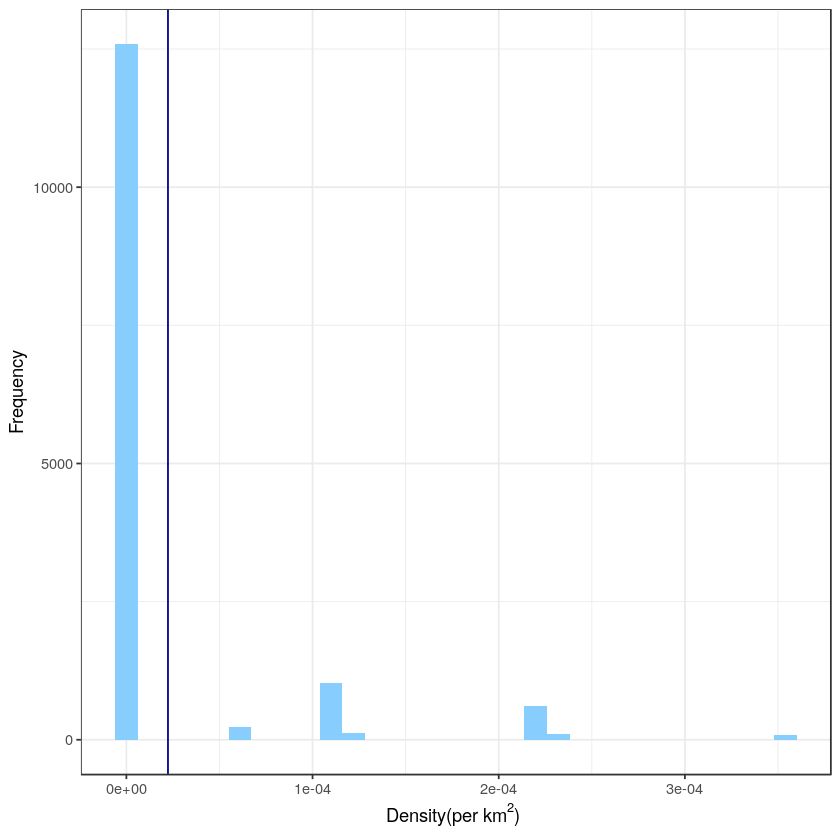

In [123]:
true_sim_den <- mean(all_sims$Density_km)


all_sim_den <- ggplot(data = all_sims) + 
                geom_histogram(aes(x=Density_km), fill = 'skyblue1') +
                xlab(expression(paste("Density(per ", km^2,")", sep=" "))) +
                ylab('Frequency') +
                theme_bw()
all_sim_den + geom_vline(xintercept = true_sim_den, color = 'darkblue')


standard_deviation <- sd(Density_km)
#plot(density(Density_km))

**Density estimates for all simulations are highly variable (low precision and low accuracy)**.All estimates are discrete right and highly skewed which is why I have chosen histogram over boxplot or density plot.

#### Analysis of each combination

So, where is this variation coming from?
* Look at the variation within combinations (10 runs for all 1344 combos), is the variation consistent? i.e, for one combination, will you have a small standard deviation in x number of runs.
* Look at variation among combinations - what is the coefficient of variation, which combos are outlining, do they all have something in common?

In [124]:
per_sim_density <- function(df){
  
  # Calculate density for each simulation and add
  Density_km <- calcDensity(df$Actual_hits, df$Area_km)
  False_Density_km <- calcDensity(df$Total_hits, df$Area_km)
  
  df <- cbind(df, Density_km)
  df <- cbind(df, False_Density_km)
  
  return(df)
}


for(i in 1:length(current_sims)){
    #df <- [[i]]
    Area_km <- calcArea(current_sims[[i]])*timestep
    current_sims[[i]] <- cbind(current_sims[[i]], Area_km)
    current_sims[[i]] <- per_sim_density(current_sims[[i]])
}



#calcArea(current_sims[[1]])
#current_sims[[1]]

Animal,Animal_path,Camera,UAV_path,Speed,Bias,Total_hits,Actual_hits,Area_km,Density_km,False_Density_km
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
reef,straight,garmin,lawnmower,1,yes,7,2,9296,0.0002151463,0.0007530120
reef,straight,garmin,lawnmower,1,no,6,2,9296,0.0002151463,0.0006454389
reef,straight,garmin,lawnmower,2,yes,8,2,9296,0.0002151463,0.0008605852
reef,straight,garmin,lawnmower,2,no,8,2,9296,0.0002151463,0.0008605852
reef,straight,garmin,figure8,1,yes,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,1,no,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,2,yes,0,0,9296,0.0000000000,0.0000000000
reef,straight,garmin,figure8,2,no,0,0,9296,0.0000000000,0.0000000000
reef,straight,sony,lawnmower,1,yes,0,0,8475,0.0000000000,0.0000000000


In [152]:
per_density_table <- function(df){
  ##### Calculate density for each individual combination ####
  den_vect <- subset(df, select = ('Density_km'))
  #print(den_vect)
  return(den_vect)
}

den_table <- c(1:1344)
for(i in current_sims){
  t <- per_density_table(i)
  den_table <- cbind(den_table, t)
}

cols.dont.want <- c('den_table')
den_table <- den_table[, ! names(den_table) %in% cols.dont.want, drop = F]
#den_table


### Analyze density table for mean, sd and cv for all runs of each combination
combo_mean <- apply(den_table, 1, function(x) mean(x))
combo_sd <- apply(den_table, 1, function(x) sd(x))

combo_stats <- cbind(combo_mean, combo_sd)

combo_cv <- apply(combo_stats, 1, function(x) (x[2]/ x[1])*100)
combo_stats <- cbind(combo_stats, combo_cv)
     
# Remove NaNs
is.nan.data.frame <- function(x)
do.call(cbind, lapply(x, is.nan))

combo_stats[is.nan(combo_stats)] <- 0
                  
#combo_stats
             

From combo_stats table, we expect the standard deviation. and thus coefficient of variation, to be very small. The same flight under the same conditions would mostly yield the same result. Speed however will change during the flight which will affect capture - important to note for later analysis.

In [153]:
# How much does mean density differ among flights? 
# You have done this above when looking at mean density differing among all simulations -
# This suggests little within flight variation
# hist(combo_mean)

# Does the variation within flights differ among flights?
# hist(combo_sd)
# Nope

#hist(combo_cv)
# Coefficient of variation indicates some big outliers - should investigate

all_com <- cbind(sim1[1:6], combo_stats)
#non_zero_com <- all_com[apply(all_com[,-1], 1, function(x) !all(x==0)),]


#all_com

iqr <- summary(all_com$combo_cv)
outliers <- sum(all_com$combo_cv > 0) # 1255 have no cv, 89 do.
outliers_pos <- which(all_com$combo_cv > 0)

# Subset sims with a higher variation
out_df <- all_com[outliers_pos,]
#out_df - A lot of them are birds which travel faster

#### Assess density estimates vs. abundance

Randomly sample from all_sims and calculate mean density estimate. 

In [219]:
abundance_gen <- function(n, df = all_sims){
    # Randomly select rows to represent abundance
    n <- sample_n(df, n)
    return(n)
}


abundance_density <- function(df){
    z <- sum(den1$Actual_hits)
    A <- sum(den1$Area_km)
    density <- calcDensity(z, A)
}

#random10 <- abundance_gen(10)
#random30 <- abundance_gen(30)
#random50 <- abundance_gen(50)
#random70 <- abundance_gen(70)
#random100 <- abundance_gen(100)
#random120 <- abundance_gen(120)

abund_table <- function(str_list){
    # Calculate the overall density and standard distribution for subset
    table <- data.frame('Abundance'= 0, 'Density'= 0, 'S_D' = 0)
    for(i in str_list){
        set <- abundance_gen(i)
        density <- abundance_density(set)
        stand_dev <- sd(set$Density_km)
        row <- c(i, density, stand_dev)
        table <- rbind(table, row)
    }
    table <- table[-1,]
    colnames(table) <- c("Abundance", "Density", "SD")
    return(table)
}



abundances <- c(100,300,500,700,1000,1200)

ab <- abund_table(abundances)
#colnames(ab) <- c("Abundance", "Density", "SD")

abund_graph <- ggplot(ab, aes(x = Abundance, y = Density)) +
                    geom_line()+
                    geom_point()
ab

,Abundance,Density,SD
,<dbl>,<dbl>,<dbl>
2,100,0.000172117,5.446606e-05
3,300,0.000172117,6.690403e-05
4,500,0.000172117,5.573512e-05
5,700,0.000172117,5.894577e-05
6,1000,0.000172117,6.429961e-05
7,1200,0.000172117,5.990501e-05


**Most of the data is 0 and density for an array of abundances are turning out to be the same. Either :**
1. More simulations
2. Cut out 0s and explore the impact of abundance on density if hits occur.
3. Look at encounter rate instead of density.

Lucas(2015) percentage errors are a bit strange - they go into the minus. I know percentage error is different to the total standard as it takes the distance of each individual estimate to the true mean.

#### Assess density estimates vs. encounter rate

Will the number of hits affect model precision and accuracy?

Actual_hits,Encounters,Area,hit_dens,s_d,hit_error
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,12592,147443741,8.540207e-05,0.000000e+00,0.000000e+00
1,665,8043214,8.267839e-05,2.626448e-05,1.313224e-05
2,1434,19365083,7.405081e-05,5.335700e-05,2.667850e-05
3,93,816378,1.139178e-04,3.306981e-05,1.653491e-05


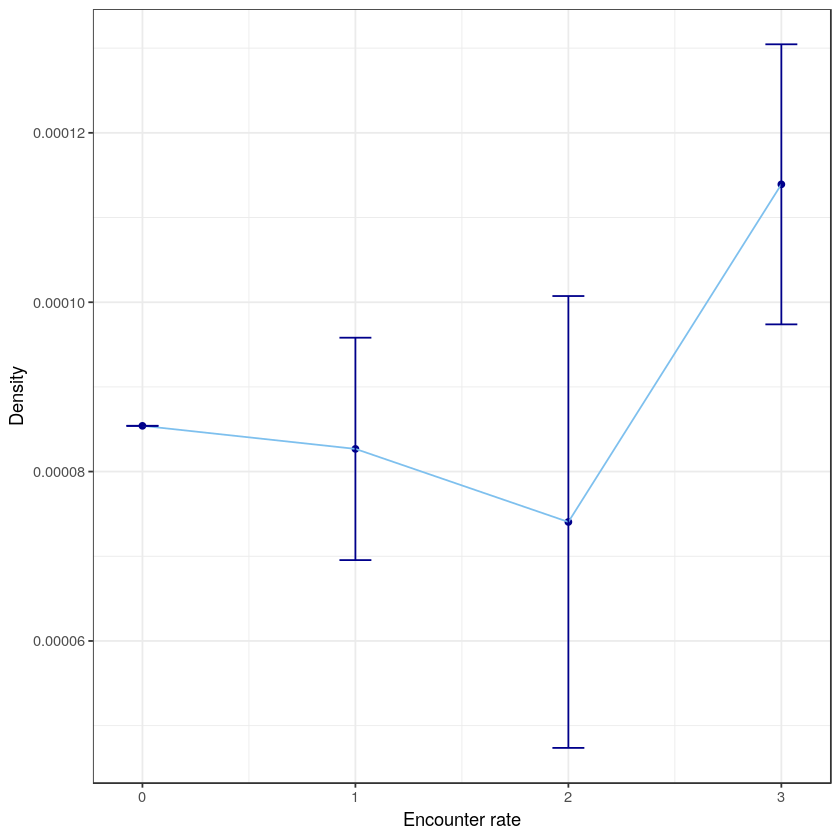

In [257]:
hit_tab <- all_sims %>% 
            group_by(Actual_hits) %>%
                summarise(Encounters = length(Actual_hits),
                          Area = sum(Area_km))

hit_sd <- function(df1, df2){
    s_d <-c()
    for(i in df1$Actual_hits){
        df <- subset(df2, df2$Actual_hits == i)
        stand <- sd(df$Density_km)
        s_d <- c(s_d, stand)
    }
    return(s_d)
}

s_d <- hit_sd(hit_tab, all_sims)
hit_dens <- apply(hit_tab, 1, function(x) calcDensity(x[2],x[3]))
hit_tab <- cbind(hit_tab, hit_dens)
hit_tab <- cbind(hit_tab, s_d)

hit_error <- sapply(s_d, function(x) x/2)
hit_tab <- cbind(hit_tab, hit_error)        
hit_tab
                  
hit_plot <- ggplot(hit_tab, aes(x=Actual_hits, y = hit_dens)) +
                  geom_point(colour="darkblue")+
                  geom_line(colour='skyblue2') +
                  geom_errorbar(aes(ymin=hit_dens-hit_error, ymax = hit_dens+hit_error), width=.15,
                 position=position_dodge(0.05), colour='darkblue')

hit_plot + labs(x="Encounter rate", y = "Density")+
   theme_bw() 
   

### Impact of variables

Split data into groups to assess how density estimates change with:

1. Area
2. Species
3. Species path
4. Bias
5. Flight path
6. Flight seed

In [316]:
# Dplyr subset by diffferent categories and compare model precision and accuracy

animal <- all_sims %>% 
            group_by(Animal) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))

animal_path <- all_sims %>% 
            group_by(Animal_path) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))


camera <- all_sims %>% 
            group_by(Camera) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))


uAV_path <- all_sims %>% 
            group_by(UAV_path) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))


speed <- all_sims %>% 
            group_by(Speed) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))


bias <- all_sims %>% 
            group_by(Bias) %>%
                summarise(Encounters = sum(Actual_hits),
                          Area = sum(Area_km))




hit_sd <- function(df1, df2, variable){
    df1 <- as.data.frame(df1)
    s_d <-c()
    for(i in df1[,1]){
        animal <- as.character(i)
        df <- subset(df2, df2$variable == animal)
        print(s_d)
        stand <- sd(df$Density_km)
        s_d <- c(s_d, stand)
    }
    return(s_d)
}

get_sd <- function(variable){
    return(hit_sd(variable, all_sims))
}


#variables <- list(animal, animal_path, camera, uav_path, speed, bias)
#for(i in variables){
#    s_d <- get_sd(i)
#    print(s_d)
#    hit_dens <- apply(i, 1, function(x) calcDensity(x[2],x[3]))
#    i <- cbind(i, hit_dens)
#    i <- cbind(i, s_d)
#}

#Animal <- as.data.frame(Animal)
#s_d <- c()
#for(i in Animal[,1]){
#    test <- subset(all_sims, all_sims$Animal == i)
#    stand <- sd(test$Density_km)
#    s_d <- c(s_d, stand)
#}

#for(i in 1:length(Animal[,1])){
#    print(i)
#}

#typeof(Animal)
test <- hit_sd(Animal, all_sims, Animal)
test
#s_d
#test <- subset(all_sims, all_sims$Animal == (animal[[1,1]]))
#test

NULL
[1] NA
[1] NA NA
[1] NA NA NA
[1] NA NA NA NA
[1] NA NA NA NA NA
[1] NA NA NA NA NA NA
[1] NA NA NA NA NA NA NA


[1] NA NA NA NA NA NA NA NA

In [308]:
animal[[1,1]]

[1] booby
Levels: booby frigate manatee nurse ray reef tern whale_shark

In [264]:
1848*8

[1] 14784